En la clase anterior, vimos como la aleatoriedad ayuda a escapar de óptimos locales. Sin embargo, es posible que eso no sea suficiente. Tabú Search y Simmulated Annealing son dos metaheurísticas locales (parten de una solución inicial y van explorando) que se centran en escapar de óptimos locales: 

- Simmulated Annealing va aceptando empeoramientos con probabilidad decreciente, inspirado en el proceso físico de enfriamiento de metales.
- Tabú search prohibe movimientos recientes, teniendo memoria de cada uno de sus movimientos.

# Coloración de grafos 

Dado un grafo $G=(V,E)$ queremos asignar a cada vértice $v\in V$ un color $c(v)\in\lbrace 1,\dots,k\rbrace$ de modo que **ninguna arista** $(u,v)\in E$ tenga extremos del mismo color: 

$$c(u)\neq c(v)\;\;\;\forall (u,v)\in E$$ 

Para un $k\geq 3$ el problema es **NP-completo**. 

Este problema se ocupa principalmente en *scheduling* y *timetabling*. Imaginemos que debemos fijar un calendario para exámenes. Los vértices serían los ramos y las aristas determinan si comparten estudiantes. Así, los colores llegarían a ser los bloques de tiempo.

Por el otro lado, un ejemplo clásico de *scheduling* sería tener los vértices como trabajos y aristas si no pueden ejecutarse simultáneamentes. Los colores llegarían a ser slots o máquinas. 

Para este problema trabajaremos con la instancia `gcol15` [otorgada por OR-tools](https://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/). Este problema se clasifica como uno de dificultad media. A continuación, dos funciones auxiliares para leer y graficar las instancias.

In [1]:
import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from helpers import graficarColoracion, cargarInstanciaORTools

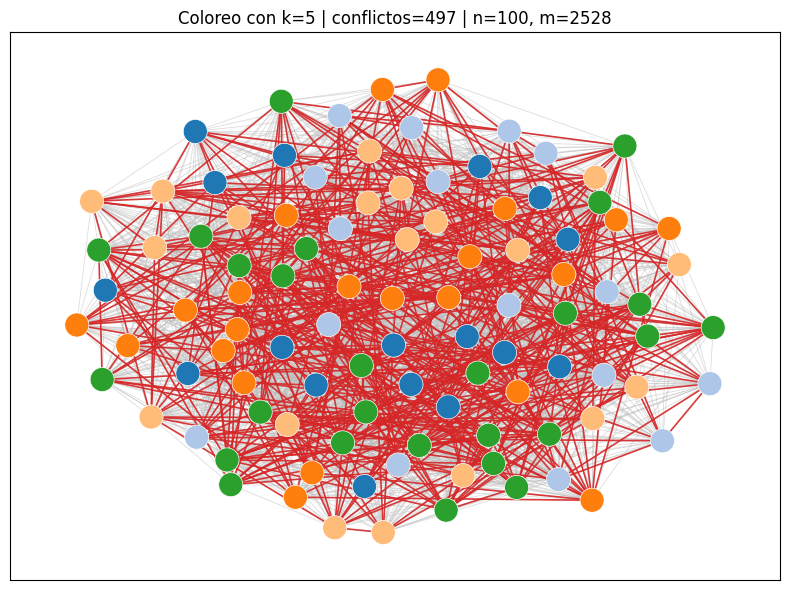

In [2]:
G, meta = cargarInstanciaORTools("../data/gcol15.txt", relabel_zero_based=True)

rng = np.random.default_rng(7)
k_demo = 5
colors_demo = rng.integers(
    0, k_demo, size=G.number_of_nodes()
)  # Elegimos colores aleatoriamente

graficarColoracion(
    G, colors=colors_demo, k=k_demo, highlight_conflicts=True, with_labels=False
)

En este problema, el Tabú Search intentaría ir cambiando los colores, incluso aceptando soluciones peores. La gracia está en que si un movimiento se efectúa, entonces no se podrá revertir tal movimiento por `tenure` iteraciones, a no ser que el movimiento mejore la mejor solución encontrada hasta el momento. 

Así, partiendo de una solución inicial, nos paramos en un vértice y evaluamos cuál es el mejor vecino para cambiar el color. Añadimos a la lista el movimiento que hicimos tal que no se puede revertir por `tenure` iteraciones y repetimos. Vamos a parar si llegamos a tener 0 conflictos o llegamos a `max_iter`. 

In [3]:
def tabu_coloring(
    G, k, colors_init=None, max_iter=1500, tenure=10, seed=0, verbose=True
):
    """
    Tabu Search para k-coloring

    Parámetros
    ----------
    G : networkx.Graph
    k : int
        Cantidad de colores a trabajar
    colors_init : dict|array|None
       El punto inicial, si no se le pasa nada, parte de un punto aleatorio
    max_iter : int
        Cantidad máxima de iteraciones
    tenure : int
        Tamaño de la lista de movimientos prohibidos
    seed : int
    verbose : bool

    Retorna
    -------
    dict con:
      'best_conflicts' : int
      'colors_best'    : dict {nodo: color}
      'history'        : lista de conflictos actuales por iter
      'best_history'   : lista del mejor global por iter
    """
    rng = np.random.default_rng(seed)

    nodes = list(G.nodes())
    n = len(nodes)
    pos_of = {u: i for i, u in enumerate(nodes)}
    nbrs = [[pos_of[v] for v in G[u]] for u in nodes]

    # -----
    # Inicialización
    # -----
    if colors_init is None:
        colors = rng.integers(0, k, size=n, dtype=int)
        if verbose:
            print("[Init] aleatorio.")
    else:
        if isinstance(colors_init, dict):
            colors = np.zeros(n, dtype=int)
            for u in nodes:
                if u not in colors_init:
                    raise ValueError(
                        f"colors_init (dict) no trae color para el nodo {u}"
                    )
                colors[pos_of[u]] = int(colors_init[u])
        else:
            colors = np.asarray(list(colors_init), dtype=int)
            if colors.size != n:
                raise ValueError(
                    f"colors_init debe tener largo n={n}, se obtuvo {colors.size}."
                )

        cmin, cmax = int(colors.min()), int(colors.max())
        if cmin < 0 or cmax >= k:
            raise ValueError(
                f"Los colores iniciales deben estar en [0..{k-1}] (observado [{cmin}..{cmax}])."
            )
        if verbose:
            print("[Init] usando punto inicial entregado.")

    # -----
    # Funciones auxiliares
    # -----
    def conflicts_of(arr):
        cnt = 0
        for u, v in G.edges():
            if arr[pos_of[u]] == arr[pos_of[v]]:
                cnt += 1
        return cnt

    def delta_if_recolor(i, new_c):
        old_c = colors[i]
        if new_c == old_c:
            return 0
        same_old = 0
        same_new = 0
        for j in nbrs[i]:
            cj = colors[j]
            if cj == old_c:
                same_old += 1
            if cj == new_c:
                same_new += 1
        return same_new - same_old  # <0 mejora

    # -----
    # Estado inicial
    # -----
    curr_conf = conflicts_of(colors)
    best_conf = curr_conf
    best_colors = colors.copy()

    history = [curr_conf]
    best_history = [best_conf]

    # matriz tabú: hasta qué iter está prohibido (i -> color c)
    tabu_until = np.zeros((n, k), dtype=int)

    if verbose:
        print(f"[Init] k={k} | conflictos iniciales={curr_conf}")

    # -----
    # Loop principal
    # -----
    for it in range(1, max_iter + 1):
        best_move = None
        best_delta = +(10**9)  # buscamos el MÁS NEGATIVO (mejor mejora)

        # explorar todo el vecindario
        for i in range(n):
            old_c = colors[i]
            for new_c in range(k):
                if new_c == old_c:
                    continue

                delta = delta_if_recolor(i, new_c)
                is_tabu = tabu_until[i, new_c] > it

                # aspiración: permitir si mejora el mejor global
                if is_tabu and (curr_conf + delta >= best_conf - 1e-12):
                    continue

                if (delta < best_delta - 1e-12) or (
                    abs(delta - best_delta) <= 1e-12 and rng.random() < 0.5
                ):
                    best_delta = delta
                    best_move = (i, new_c)

        if best_move is None:
            if verbose:
                print(f"[Iter {it}] sin movimiento admisible; paro.")
            break

        # aplicar movimiento
        i, new_c = best_move
        old_c = colors[i]
        colors[i] = new_c
        curr_conf += best_delta

        # actualizar tabú: no volver a old_c por 'tenure' + un número aleatorio
        tabu_until[i, old_c] = it + tenure + rng.integers(0, 3)

        # actualizar mejor global
        if curr_conf < best_conf - 1e-12:
            best_conf = curr_conf
            best_colors = colors.copy()

        history.append(curr_conf)
        best_history.append(best_conf)

        if verbose and (it % 50 == 0 or it == 1):
            print(f"[Iter {it}] curr={curr_conf} | best={best_conf}")

        if best_conf == 0:
            if verbose:
                print(f"[OK] k-coloración válida encontrada en iter {it}.")
            break

    colors_best = {nodes[i]: int(best_colors[i]) for i in range(n)}
    return {
        "best_conflicts": int(best_conf),
        "colors_best": colors_best,
        "history": history,
        "best_history": best_history,
    }

A continuación evaluaremos el efecto de `tenure`. En específico, nos interesaría saber como se comporta tabú search con tenure cero (es decir, sin la lista de pasos prohibidos) y con valores más altos. *¿Realmente ayuda la restricción de movimientos para óptimos locales?*

[A] tenure=0 (sin tabú): best_conflicts = 57
[A] tenure=5: best_conflicts = 47
[A] tenure=15: best_conflicts = 45


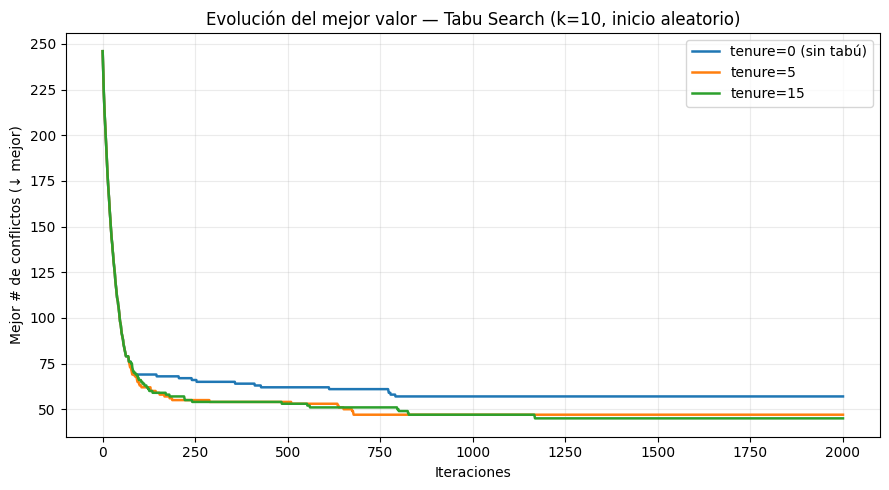

In [4]:
import matplotlib.pyplot as plt

# -----
# Parámetros del experimento
# -----
k = 10  # número de colores
seed = 7  # semilla fija para comparabilidad
max_iter = 2000  # iteraciones máximas del TS
tenures = [0, 5, 15]  # valores a comparar


# -----
# Iterar por cada tenure
# -----
runs_tenure = []
for T in tenures:
    sol = tabu_coloring(
        G,
        k=k,
        colors_init=None,  # inicia aleatorio
        max_iter=max_iter,
        tenure=T,
        seed=seed,
        verbose=False,
    )
    label = f"tenure={T}" if T > 0 else "tenure=0 (sin tabú)"
    print(f"[A] {label}: best_conflicts = {sol['best_conflicts']}")
    runs_tenure.append((label, sol))

# -----
# Graficar
# -----
fig, ax = plt.subplots(figsize=(9, 5))
for label, sol in runs_tenure:
    y = sol["best_history"]
    x = list(range(len(y)))  # iteraciones (incluye estado inicial)
    ax.plot(x, y, label=label, linewidth=1.8)

ax.set_xlabel("Iteraciones")
ax.set_ylabel("Mejor # de conflictos (↓ mejor)")
ax.set_title(f"Evolución del mejor valor — Tabu Search (k={k}, inicio aleatorio)")
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

A continuación, intentaremos resolver el mismo problema con **Simulated Annealing**. 

La idea es partir de una solución $s$ y una temperatura $T>0$. En cada paso, generamos un vecino $s'$. Si el vecino mejora nuestra solución, lo aceptamos; si lo empeora, lo aceptamos con probabilidad Metropolis: 

$$P(\text{aceptar})=\exp\left(-\frac{\Delta}{T}\right)$$ 

Donde $\Delta$ llegaría a ser el margen con el que se empeora el valor objetivo. 

La temperatura la iremos aumentando, tal que al final de las iteraciones será muy difícil aceptar una solución mala. 

Por lo mismo, Simulated Annealing nos ayudará a escapar de soluciones locales y luego quedarnos plantados en el nuevo punto óptimo.

A continuación tienen la función `simulated_annealing` , que recibe los siguientes parámetros: 

- `G`: El grafo de entrada
- `k`: La cantidad de colores a resolver
- `schedule`: La forma en que la temperatura va decayendo. Se tienen las siguientes opciones:
  * `geom`: Corresponde a una serie geométrica:
$$T_{t+1}=T_t\cdot\text{decay}$$ 
  * `exp`: Decae en función de una exponencial con respecto la iteración
$$T_{t+1}=T_0\cdot\exp(-\text{decay}\cdot t)$$
  * `arith`: Decae de forma aritmética
$$T_{t+1}=T_t-\text{decay}$$
- `init_temp`: Temperatura inicial
- `decay`: Razón de pérdida de temperatura
- `max_attempts`: Cantidad de intentos a realizar sin recibir ninguna mejora. Si no hay mejora en `max_attempts` iteraciones, paramos.
- `max_iters`: Tope global de iteraciones
- `seed`: Semilla aleatoria
- `verbose`: Añadir prints

In [5]:
import mlrose_hiive as mlrose


def simulated_annealing(
    G,
    k,
    schedule="geom",  # "geom" | "exp" | "arith"
    init_temp=5.0,
    decay=0.995,  # geom/exp: razón; arith: decremento
    min_temp=1e-3,
    max_attempts=200,  # intentos sin mejora por nivel
    max_iters=20000,  # tope global
    seed=0,
    verbose=True,
):
    """
    Ejecuta Simulated Annealing para k-coloring.

    Parámetros:
    -----------
    G: networkx.Graph

    k: int
        número de colores (0..k-1).

    schedule: str | geom
        Puede ser "geom", "exp" o "arith". Determina como se va enfriando la temperatura

    init_temp: float | 5.0
        Temperatura inicial, mientras más alta, más abierta está a probar movimientos nuevos

    decay: float | 0.995
        Tasa de enfriamento

    max_attempts: int | 200
        Si pasan `max_attempts` iteraciones sin mejorar, el algoritmo se detiene

    max_iters: int | 20000
        Tope global de iteraciones

    seed: int | 0
        Semilla

    verbose: bool | True
        Añadir prints en la ejecución


    Retorna:
    --------
    dict:
      - 'best_conflicts': int (# aristas con extremos del mismo color)
      - 'colors': {nodo: color}
      - 'curve': np.ndarray (historia del fitness)
      - 'k': k usado
    """

    # -----
    # Asegurar el mapeo 0..n-1 para mlrose
    # -----
    nodes = list(G.nodes())
    n = len(nodes)
    need_relabel = set(nodes) != set(range(n))
    if need_relabel:
        mapping = {u: i for i, u in enumerate(nodes)}
        G_work = nx.relabel_nodes(G, mapping, copy=True)
        rev = {i: u for u, i in mapping.items()}
    else:
        G_work = G
        rev = {i: i for i in range(n)}

    # -----
    # Pasar el problema a MLRose
    # -----
    edges = list(G_work.edges())
    fitness = mlrose.MaxKColor(edges)  # fitness = #conflictos (minimizar)
    problem = mlrose.DiscreteOpt(
        length=n, fitness_fn=fitness, maximize=False, max_val=k
    )

    # -----
    # Forma en que determinaremos el enfriamiento
    # -----
    if schedule == "geom":
        sch = mlrose.GeomDecay(init_temp=init_temp, decay=decay, min_temp=min_temp)
    elif schedule == "exp":
        sch = mlrose.ExpDecay(init_temp=init_temp, exp_const=decay, min_temp=min_temp)
    elif schedule == "arith":
        sch = mlrose.ArithDecay(init_temp=init_temp, decay=decay, min_temp=min_temp)
    else:
        raise ValueError("schedule debe ser 'geom' | 'exp' | 'arith'.")

    # -----
    # Simulated Annealing: llamar a la función
    # -----
    best_state, best_conflicts, curve = mlrose.simulated_annealing(
        problem,
        schedule=sch,
        max_attempts=max_attempts,
        max_iters=max_iters,
        curve=True,
        random_state=seed,
    )

    # -----
    # Reconstruir colores por nodo original
    # -----
    colors_idx = {i: int(best_state[i]) for i in range(n)}
    colors = {rev[i]: c for i, c in colors_idx.items()}

    if verbose:
        print(
            f"[SA k={k}] best_conflicts={int(best_conflicts)} | "
            f"coloreo_válido={bool(best_conflicts == 0)}"
        )

    return {
        "best_conflicts": int(best_conflicts),
        "colors": colors,
        "curve": curve,
        "k": k,
    }

Como podemos ver, unas de las gracias de `simulated_annealing` es que es muy personalizable. Así, queda propuesto **superar** al tabu search (50 conflictos, aproximadamente) en el problema del coloreo. Apóyense en el gráfico anterior para poder determinar una temperatura coherente con el problema. Además, grafiquen como evoluciona la mejor respuesta en función de las iteraciones. *¿Por qué creen que Simulated Annealing da mejor/peor que Tabu Search?*

[SA k=10] best_conflicts=53 | coloreo_válido=False


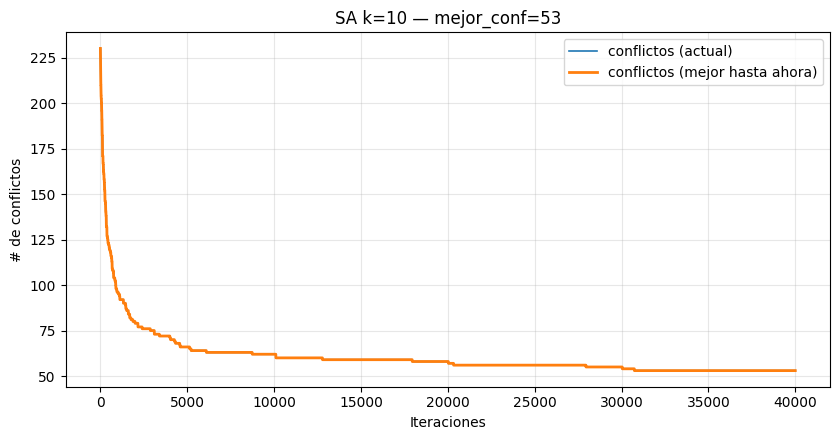

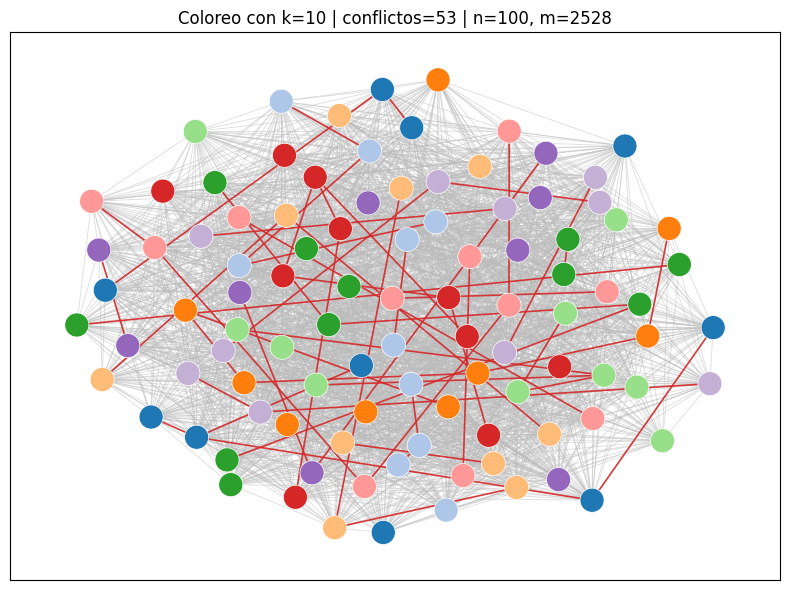

In [6]:
res = simulated_annealing(
    G,
    k=10,
    schedule="exp",  # "geom" | "exp" | "arith"
    init_temp=10.0,
    decay=0.990,
    min_temp=1e-3,
    max_attempts=2000,
    max_iters=40000,
    seed=0,
    verbose=True,
)


# -----
# Graficamos
# -----

# -----
# Obtenemos la curva
# -----
curve = np.asarray(res["curve"])

if curve.ndim == 1:
    curr = curve.astype(float)
elif curve.ndim >= 2:
    curr = curve[:, 0].astype(float)
else:
    curr = curve.ravel().astype(float)

best_so_far = np.minimum.accumulate(curr)
iters = np.arange(1, len(curr) + 1)

plt.figure(figsize=(8.5, 4.5))
plt.plot(iters, curr, lw=1.2, label="conflictos (actual)")
plt.plot(iters, best_so_far, lw=2.0, label="conflictos (mejor hasta ahora)")
plt.xlabel("Iteraciones")
plt.ylabel("# de conflictos")
plt.title(f"SA k={res['k']} — mejor_conf={res['best_conflicts']}")
plt.grid(alpha=0.3)
plt.legend()
if res["best_conflicts"] == 0:
    plt.axhline(0, ls="--", lw=1, color="gray")
plt.tight_layout()
plt.show()

graficarColoracion(G, colors=res["colors"], k=res["k"], highlight_conflicts=True)

# Aplicación en el TSP

En esta ocasión, utilizaremos instancias de [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/), sitio web con varias instancias para el problema del vendedor viajero. 

Instalaremos la versión de TSPlib tal que no interfiera con las dependencias del entorno virtual

In [7]:
!pip install tsplib95==0.7.1 --no-deps
!pip install deprecated wrap


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


Con esta librería podemos cargar los archivos `.tsp`

In [8]:
import tsplib95

PROB_PATH = "data/berlin52.tsp"
problem = tsplib95.load(PROB_PATH)

node_ids = list(problem.get_nodes())
coords = np.array([problem.node_coords[i] for i in node_ids], dtype=float)

print(f"Instancia: {problem.name} | N = {len(node_ids)}")

Instancia: berlin52 | N = 52


Primero, veamos como simulated annealing encuentra la solución óptima, en función de los distintos schedules. Nos daremos como punto de comparación algún algoritmo greedy, partiendo como semilla constructiva el algoritmo greedy también.

In [9]:
# Le pasamos el problema a ML-Hive
problem_sa = mlrose.TSPOpt(length=len(coords), coords=[tuple(x) for x in coords])

# Enfriamiento geométrico simple
schedule = mlrose.GeomDecay(init_temp=1000.0, decay=0.995)

best_state, best_fitness, curve = mlrose.simulated_annealing(
    problem_sa,
    schedule=schedule,
    max_iters=20000,
)
print("Costo SA:", float(best_fitness))

Costo SA: 21174.47408688754


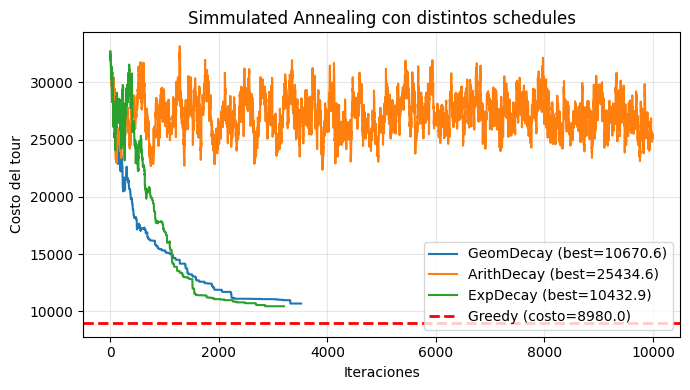

In [10]:
def graficarSchedules(coords, problem, max_iters=5000, seed=7):
    """
    Corre SA para un TSP con distintos schedules y compara
    contra un tour greedy como baseline.

    Parámetros
    ----------
    coords : np.array de shape (n,2)
        Coordenadas de la instancia TSPLIB
    problem : tsplib95.models.StandardProblem
        Problema cargado con tsplib95 (para tener get_graph())
    max_iters : int
        Iteraciones máximas de SA
    seed : int
        Semilla aleatoria
    """

    # Definir problema para mlrose-hiive
    tsp_problem = mlrose.TSPOpt(length=len(coords), coords=[tuple(x) for x in coords])

    schedules = {
        "GeomDecay": mlrose.GeomDecay(init_temp=1000.0, decay=0.995),
        "ArithDecay": mlrose.ArithDecay(init_temp=1000.0, decay=0.0001),
        "ExpDecay": mlrose.ExpDecay(init_temp=5000.0, exp_const=0.005, min_temp=1.0),
    }

    plt.figure(figsize=(7, 4))

    for name, sched in schedules.items():
        _, best_fitness, curve = mlrose.simulated_annealing(
            tsp_problem,
            schedule=sched,
            max_attempts=200,
            max_iters=max_iters,
            random_state=seed,
            curve=True,
        )
        plt.plot(curve[:, 0], label=f"{name} (best={best_fitness:.1f})")

    # Baseline greedy con NetworkX
    G = problem.get_graph()  # grafo con pesos de tsplib95
    tour_greedy = nx.approximation.greedy_tsp(G, weight="weight")
    costo_greedy = sum(G[u][v]["weight"] for u, v in zip(tour_greedy, tour_greedy[1:]))
    plt.axhline(
        y=costo_greedy,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Greedy (costo={costo_greedy:.1f})",
    )

    plt.xlabel("Iteraciones")
    plt.ylabel("Costo del tour")
    plt.title("Simmulated Annealing con distintos schedules")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Uso (ejemplo con berlin52)
graficarSchedules(coords, problem, max_iters=10000, seed=7)

Notamos que sigue sin superar al greedy. Sin embargo, la gracia de esto es que podemos ir jugando con los parámetros e ir viendo como superar la línea greedy. Veamos qué ocurre si utilizamos el algoritmo greedy como punto de partida y adaptamos nuestros parámetros de búsqueda en función de la instancia

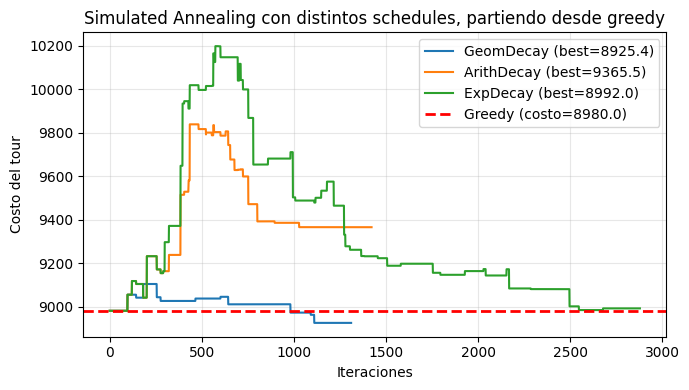

In [11]:
def graficarSchedulesGreedy(coords, problem, max_iters=5000, seed=7):
    """
    Corre SA para un TSP con distintos schedules y compara
    contra un tour greedy como baseline.

    Parámetros
    ----------
    coords : np.array de shape (n,2)
        Coordenadas de la instancia TSPLIB (en el mismo orden que 'node_ids')
    problem : tsplib95.models.StandardProblem
        Problema cargado con tsplib95 (para tener get_graph())
    max_iters : int
        Iteraciones máximas de SA
    seed : int
        Semilla aleatoria
    start_from_greedy : bool
        Si True, SA arranca desde el tour greedy (init_state=greedy)
    """

    # Definir problema para mlrose-hiive
    tsp_problem = mlrose.TSPOpt(length=len(coords), coords=[tuple(x) for x in coords])

    schedules = {
        "GeomDecay": mlrose.GeomDecay(init_temp=100.0, decay=0.995),
        "ArithDecay": mlrose.ArithDecay(init_temp=100.0, decay=0.1),
        "ExpDecay": mlrose.ExpDecay(init_temp=100.0, exp_const=0.001, min_temp=1.0),
    }

    # Baseline greedy con NetworkX
    G = problem.get_graph()
    tour_greedy = nx.approximation.greedy_tsp(
        G, weight="weight"
    )  # tour cerrado (ids TSPLIB)
    costo_greedy = sum(G[u][v]["weight"] for u, v in zip(tour_greedy, tour_greedy[1:]))

    init_state = None
    node_ids = list(problem.get_nodes())
    id2idx = {nid: i for i, nid in enumerate(node_ids)}
    init_state = [id2idx[n] for n in tour_greedy[:-1]]  # sin el cierre

    plt.figure(figsize=(7, 4))

    for name, sched in schedules.items():
        _, best_fitness, curve = mlrose.simulated_annealing(
            tsp_problem,
            schedule=sched,
            init_state=init_state,
            max_attempts=200,
            max_iters=max_iters,
            random_state=seed,
            curve=True,
        )

        curve = np.asarray(curve)
        y = curve[:, 0] if curve.ndim == 2 else curve
        plt.plot(y, label=f"{name} (best={best_fitness:.1f})")

    # Línea base Greedy
    plt.axhline(
        y=costo_greedy,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Greedy (costo={costo_greedy:.1f})",
    )

    plt.xlabel("Iteraciones")
    plt.ylabel("Costo del tour")
    plt.title("Simulated Annealing con distintos schedules, partiendo desde greedy")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


graficarSchedulesGreedy(coords, problem, max_iters=10000, seed=7)

Ahora, veamos como le va al Tabú Search en la misma instancia. Ahora, nos podemos apoyar de la librería `pycombinatorial`. 

Notemos que `pycombinatorial` posee una amplia gama de algoritmos para resolver el TSP. También tiene una implementación para simmulated annealing. Recomiendo mucho [leer la documentación](https://github.com/Valdecy/pyCombinatorial?tab=readme-ov-file). 

In [12]:
!pip install pycombinatorial


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [13]:
from pyCombinatorial.algorithm import tabu_search
from pyCombinatorial.utils import graphs, util
import random

# -----
# Obtenemos las distancias
# -----
N = len(node_ids)
W = np.zeros((N, N), dtype=float)
for i, a in enumerate(node_ids):
    for j, b in enumerate(node_ids):
        W[i, j] = problem.get_weight(a, b)

random.seed(1)
seed = util.seed_function(W)
parameters = {"iterations": 250, "tabu_tenure": 75, "verbose": True}

route, distance = tabu_search(W, seed, **parameters)

print(f"Distancia TS (Tabu Search): {distance:.2f}")

Iteration =  0 Distance =  30745.0
Iteration =  1 Distance =  28760.0
Iteration =  2 Distance =  27310.0
Iteration =  3 Distance =  25639.0
Iteration =  4 Distance =  24388.0
Iteration =  5 Distance =  24013.0
Iteration =  6 Distance =  23762.0
Iteration =  7 Distance =  23192.0
Iteration =  8 Distance =  22211.0
Iteration =  9 Distance =  22055.0
Iteration =  10 Distance =  20846.0
Iteration =  11 Distance =  20846.0
Iteration =  12 Distance =  19775.0
Iteration =  13 Distance =  18546.0
Iteration =  14 Distance =  18546.0
Iteration =  15 Distance =  18546.0
Iteration =  16 Distance =  18493.0
Iteration =  17 Distance =  18493.0
Iteration =  18 Distance =  18493.0
Iteration =  19 Distance =  17686.0
Iteration =  20 Distance =  16781.0
Iteration =  21 Distance =  16781.0
Iteration =  22 Distance =  15969.0
Iteration =  23 Distance =  15774.0
Iteration =  24 Distance =  15314.0
Iteration =  25 Distance =  14587.0
Iteration =  26 Distance =  14587.0
Iteration =  27 Distance =  14587.0
It

Notemos que la solución es mucho mejor que la del Simmulated Annealing. Podemos ver la ruta con la función `plot_tour`

In [14]:
graphs.plot_tour(coords, city_tour=route, view="browser", size=8)

Por último, veamos como se vería la combinación de Ant Colony Optimization con Tabú Search. Recordemos que los algoritmos hormigas se aprovechan de la **memoría**. 

Nos definimos un parámetro $\tau$ que llegarían a ser las *"feromonas"* y otro $\mu$ que es la atracción *"instantanea* (por ejemplo, $1/d_{ij}$). 

Así, cada hormiga elige la ciudad siguiente en base a la siguiente regla probabilística:

$$P_{ij}=\frac{\tau_{ij}^{\alpha}\mu_{ij}^{\beta}}{\sum_{k\in\text{no visitadas}}\tau_{ik}^{\alpha}\mu_{ik}^{\beta}}$$ 

Con $\alpha$ y $\beta$ parámetros que controlan cuanto pesa la feromona y heurística. 

Se tiene otro parámetro de `decay` que introduce una *"evaporación"* de las feromonas $\tau_{ij}\leftarrow(1-\rho)\tau_{ij}$.

Veamos que juntando dos heurísticas incluso se puede llegar a una mejor solución con **menos iteraciones**.

In [21]:
from pyCombinatorial.algorithm import ant_colony_optimization

parameters = {
    "ants": 15,
    "iterations": 10,
    "alpha": 1,  # Más alta, más memoria (explotación)
    "beta": 2,  # Más alta, es más greedy con aristas cortas.
    "decay": 0.05,
    "local_search": False,  # Si después de construir el tour aplicamos 2-opt para mejorar localmente
    "verbose": True,
}

route, distance = ant_colony_optimization(W, **parameters)
city_tour = [route, float(distance)]

parameters = {"iterations": 50, "tabu_tenure": 15, "verbose": True}

route, distance = tabu_search(W, city_tour, **parameters)

print(f"Distancia: {distance:.2f}")

Iteration = 1, Distance = 13832.0
Iteration = 2, Distance = 13657.0
Iteration = 3, Distance = 13532.0
Iteration = 4, Distance = 13532.0
Iteration = 5, Distance = 13532.0
Iteration = 6, Distance = 13532.0
Iteration = 7, Distance = 13532.0
Iteration = 8, Distance = 13518.0
Iteration = 9, Distance = 13518.0
Iteration = 10, Distance = 12897.0
Iteration =  0 Distance =  12897.0
Iteration =  1 Distance =  12897.0
Iteration =  2 Distance =  12897.0
Iteration =  3 Distance =  12897.0
Iteration =  4 Distance =  12844.0
Iteration =  5 Distance =  12483.0
Iteration =  6 Distance =  12483.0
Iteration =  7 Distance =  12483.0
Iteration =  8 Distance =  12188.0
Iteration =  9 Distance =  11758.0
Iteration =  10 Distance =  11758.0
Iteration =  11 Distance =  11758.0
Iteration =  12 Distance =  11758.0
Iteration =  13 Distance =  11559.0
Iteration =  14 Distance =  11559.0
Iteration =  15 Distance =  11207.0
Iteration =  16 Distance =  11207.0
Iteration =  17 Distance =  11207.0
Iteration =  18 Dista